In [1]:
# ---------------- Top of file: imports ----------------
import os
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.amp import autocast, GradScaler

# ---------------- Phase 0: global seeding ----------------
SEED = 1337
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


# Reproducibility flags
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Optional (stricter, may slow down & restrict some ops):
# torch.use_deterministic_algorithms(True)


# Protein Secondary Structure (Q8) Prediction: Data Prep and Modeling

## Configuration and Data Loading

Here, we define global constants like the data file name and batch size. We then:
1.  Load the dataset from the specified `.csv` file.
2.  Perform an initial cleaning step by filtering out any protein sequences that contain the non-standard amino acid character (`*`).
3.  Select only the columns needed for this task (`seq`, `sst3`, `sst8`, `len`).

In [2]:

# --- 1. Configuration and Data Loading ---
DATA_FILE = '2018-06-06-pdb-intersect-pisces.csv'
BATCH_SIZE = 64 # Recommended standard batch size
TEST_SIZE = 0.15 
VAL_SIZE = 0.15  

# Load the dataset
try:
    df = pd.read_csv(DATA_FILE)
except FileNotFoundError:
    print(f"Error: The file '{DATA_FILE}' was not found. Please ensure it is in the working directory.")
    exit()

# Apply the fix for the SyntaxWarning using a raw string r'\*'
# Filter out sequences that contain the nonstandard amino acid mask ('*')
df_filtered = df[~df['seq'].str.contains(r'\*')].copy()

# Focus on core columns
df_filtered = df_filtered[['seq', 'sst3', 'sst8', 'len']]
print(f"Initial sequences: {len(df)}. Sequences after filtering: {len(df_filtered)}")

Initial sequences: 9078. Sequences after filtering: 8994


## Define Mappings and Tokenization

This block is for data tokenization. We create dictionaries (vocabularies) to map each character to a unique integer:
* **`aa_to_int`**: For the 20 standard amino acids (input features), plus a `PAD` token (index 0).
* **`q3_to_int`**: For the 3-class secondary structure labels (H, E, C), plus a `PAD` token (index 3).
* **`q8_to_int`**: For the 8-class labels. This includes a fix to use standard 0-indexed classes (0-7) and a separate `PAD` token (index 8).

These mappings are then applied to the dataframe to create new integer-encoded sequence columns. Finally, we find the longest sequence length (`MAX_LEN`) in the dataset.

In [3]:
# --- 2. Define Mappings and Tokenization Parameters ---
AA_ALPHABET = list("ACDEFGHIKLMNPQRSTVWY")
Q3_ALPHABET = list("HEC") 
Q8_ALPHABET = list("HECBITGS") 

# Amino Acid (Input) Mappings
aa_to_int = {aa: i + 1 for i, aa in enumerate(AA_ALPHABET)}
aa_to_int['PAD'] = 0
AA_VOCAB_SIZE = len(aa_to_int)

# Q3 Label Mappings: Classes 0, 1, 2 and PAD 3
q3_to_int = {ss: i for i, ss in enumerate(Q3_ALPHABET)} 
q3_to_int['PAD'] = 3 # PAD index is moved to 3
Q3_NUM_CLASSES = len(Q3_ALPHABET) # 3
Q3_PAD_INDEX = q3_to_int['PAD'] # 3

# --- START OF Q8 FIX ---
# Q8 Label Mappings
# H -> 0, E -> 1, ..., S -> 7 (Standard PyTorch 0-indexed classes)
q8_to_int = {ss: i for i, ss in enumerate(Q8_ALPHABET)} 
q8_to_int['PAD'] = 8 # PAD index is moved to 8 (or any number not 0-7)
Q8_NUM_CLASSES = len(Q8_ALPHABET) # 8
Q8_PAD_INDEX = q8_to_int['PAD'] # 8
# --- END OF Q8 FIX ---


# Apply tokenization to input (seq) and both labels (sst3, sst8)
df_filtered['seq_int'] = df_filtered['seq'].apply(
    lambda x: [aa_to_int.get(char, aa_to_int['PAD']) for char in x]
)
df_filtered['sst3_int'] = df_filtered['sst3'].apply(
    lambda x: [q3_to_int.get(char, q3_to_int['PAD']) for char in x]
)
df_filtered['sst8_int'] = df_filtered['sst8'].apply(
    lambda x: [q8_to_int.get(char, q8_to_int['PAD']) for char in x]
)

MAX_LEN = df_filtered['len'].max()
print(f"Max Sequence Length (MAX_LEN): {MAX_LEN}")
print(f"\nQ8 NUM CLASSES: {Q8_NUM_CLASSES} (classes 0-7)")
print(f"Q8 PAD INDEX: {Q8_PAD_INDEX} (class 8)")

Max Sequence Length (MAX_LEN): 1632

Q8 NUM CLASSES: 8 (classes 0-7)
Q8 PAD INDEX: 8 (class 8)


## Padding Sequences

To train with batches, all sequences must be the same length. This cell defines a function `apply_padding` that:
1.  Pads shorter sequences with the `PAD` value up to `MAX_LEN`.
2.  Truncates any sequences that might be longer than `MAX_LEN`.

This function is then used to create the final NumPy arrays for our features (`X`) and labels (`Y_Q3`, `Y_Q8`).

In [4]:
def apply_padding(sequences, max_len, padding_value):
    """Pads integer sequences to a fixed length using post-padding (PyTorch convention)."""
    padded_sequences = []
    for seq in sequences:
        # Calculate how much padding is needed
        pad_amount = max_len - len(seq)
        if pad_amount > 0:
            # Post-pad: sequence + [padding_value, padding_value, ...]
            padded_seq = seq + [padding_value] * pad_amount
        else:
            # Truncate if sequence is longer than MAX_LEN
            padded_seq = seq[:max_len]
        padded_sequences.append(padded_seq)
    
    # Convert list of lists to a NumPy array
    return np.array(padded_sequences, dtype=np.int64) 

# Pad and convert to NumPy arrays (PyTorch requires long/int64 for indices)
X = apply_padding(df_filtered['seq_int'].tolist(), MAX_LEN, aa_to_int['PAD'])
Y_Q3 = apply_padding(df_filtered['sst3_int'].tolist(), MAX_LEN, q3_to_int['PAD'])
Y_Q8 = apply_padding(df_filtered['sst8_int'].tolist(), MAX_LEN, q8_to_int['PAD'])
print(f"Padded Features (X) shape: {X.shape}")

Padded Features (X) shape: (8994, 1632)


## Train-Validation-Test Split

Using `sklearn.model_selection.train_test_split`, we split the data into training, validation, and test sets. We perform two splits to get all three sets.

Finally, all NumPy arrays are converted to PyTorch `Long` Tensors, which is the required data type for embedding lookups and loss functions.

In [5]:
# --- 4. Train-Validation-Test Split and PyTorch Tensor Conversion ---
val_ratio_temp = VAL_SIZE / (1 - TEST_SIZE)

# Split 1: Get Test Set
X_temp, X_test, Y_Q3_temp, Y_Q3_test, Y_Q8_temp, Y_Q8_test = train_test_split(
    X, Y_Q3, Y_Q8, test_size=TEST_SIZE, random_state=42
)

# Split 2: Get Train and Validation Sets
X_train, X_val, Y_Q3_train, Y_Q3_val, Y_Q8_train, Y_Q8_val = train_test_split(
    X_temp, Y_Q3_temp, Y_Q8_temp, test_size=val_ratio_temp, random_state=42
)

# Convert all NumPy arrays to PyTorch Tensors
X_train_t = torch.from_numpy(X_train).long()
X_val_t = torch.from_numpy(X_val).long()
X_test_t = torch.from_numpy(X_test).long()

Y_Q3_train_t = torch.from_numpy(Y_Q3_train).long()
Y_Q3_val_t = torch.from_numpy(Y_Q3_val).long()
Y_Q3_test_t = torch.from_numpy(Y_Q3_test).long()

Y_Q8_train_t = torch.from_numpy(Y_Q8_train).long()
Y_Q8_val_t = torch.from_numpy(Y_Q8_val).long()
Y_Q8_test_t = torch.from_numpy(Y_Q8_test).long()

print(f"\nTraining set size: {len(X_train_t)} | Validation set size: {len(X_val_t)} | Test set size: {len(X_test_t)}")




Training set size: 6295 | Validation set size: 1349 | Test set size: 1350


## Calculate Lengths and Trim Long Sequences

This is an important optimization step.
1.  We calculate the **true, un-padded length** of every sequence in each set (using `PAD_IDX = 0`).
2.  We define a `MAX_TRAIN_LEN` (e.g., 768) which is much smaller than the absolute max length (1632).
3.  We filter all three datasets (train, val, test) to remove any sequences longer than this threshold.

This dramatically reduces memory usage and computation time during training. The summary shows we keep >98% of the data.

In [6]:
# --- 5. Create PyTorch DataLoaders for Q3 and Q8 (Phase 1: with lengths) ---
PAD_IDX = 0
# Fix lengths after padding
L_train_t = (X_train_t != PAD_IDX).sum(dim=1)
L_val_t   = (X_val_t   != PAD_IDX).sum(dim=1)
L_test_t  = (X_test_t  != PAD_IDX).sum(dim=1)

print("New length stats:",
      "train", L_train_t.min().item(), "-", L_train_t.max().item(),
      "val", L_val_t.min().item(), "-", L_val_t.max().item())
MAX_TRAIN_LEN = 768   # ← You can adjust or set to None to disable

if MAX_TRAIN_LEN is not None:
    # Apply masks for train / val / test
    mask_train = L_train_t <= MAX_TRAIN_LEN
    mask_val   = L_val_t   <= MAX_TRAIN_LEN
    mask_test  = L_test_t  <= MAX_TRAIN_LEN

    X_train_t, Y_Q3_train_t, Y_Q8_train_t, L_train_t = (
        X_train_t[mask_train],
        Y_Q3_train_t[mask_train],
        Y_Q8_train_t[mask_train],
        L_train_t[mask_train],
    )
    X_val_t, Y_Q3_val_t, Y_Q8_val_t, L_val_t = (
        X_val_t[mask_val],
        Y_Q3_val_t[mask_val],
        Y_Q8_val_t[mask_val],
        L_val_t[mask_val],
    )
    X_test_t, Y_Q3_test_t, Y_Q8_test_t, L_test_t = (
        X_test_t[mask_test],
        Y_Q3_test_t[mask_test],
        Y_Q8_test_t[mask_test],
        L_test_t[mask_test],
    )
    total_train_before = len(L_train_t) + (~mask_train).sum().item()  # optional sanity check
    kept_train = mask_train.sum().item()
    kept_val   = mask_val.sum().item()
    kept_test  = mask_test.sum().item()

    print(f"\n--- Trim Summary ---")
    print(f"MAX_TRAIN_LEN = {MAX_TRAIN_LEN}")
    print(f"Train kept: {kept_train}/{kept_train + (~mask_train).sum().item()} "
          f"({kept_train / (kept_train + (~mask_train).sum().item()):.2%})")
    print(f"Val kept:   {kept_val}/{kept_val + (~mask_val).sum().item()} "
          f"({kept_val / (kept_val + (~mask_val).sum().item()):.2%})")
    print(f"Test kept:  {kept_test}/{kept_test + (~mask_test).sum().item()} "
          f"({kept_test / (kept_test + (~mask_test).sum().item()):.2%})")

New length stats: train 20 - 1632 val 20 - 1122

--- Trim Summary ---
MAX_TRAIN_LEN = 768
Train kept: 6242/6295 (99.16%)
Val kept:   1336/1349 (99.04%)
Test kept:  1329/1350 (98.44%)


## Create PyTorch DataLoaders

This cell prepares the data for the training loop:
1.  Creates `TensorDataset` objects, which bundle the (Features, Labels, Lengths) tensors together for both Q3 and Q8.
2.  Defines a custom `collate_triplet` function. This function tells the `DataLoader` how to combine a list of (X, Y, L) tuples into a single batch.
3.  Sets up the final `DataLoader`s for Q3 and Q8, which will feed batches to the model. The training loader is set to `shuffle=True`.

In [7]:

from torch.utils.data import TensorDataset, DataLoader

# Datasets now include lengths (X, Y, L)
train_ds_q3 = TensorDataset(X_train_t, Y_Q3_train_t, L_train_t)
val_ds_q3   = TensorDataset(X_val_t,   Y_Q3_val_t,   L_val_t)
test_ds_q3  = TensorDataset(X_test_t,  Y_Q3_test_t,  L_test_t)

train_ds_q8 = TensorDataset(X_train_t, Y_Q8_train_t, L_train_t)
val_ds_q8   = TensorDataset(X_val_t,   Y_Q8_val_t,   L_val_t)
test_ds_q8  = TensorDataset(X_test_t,  Y_Q8_test_t,  L_test_t)

# Collate: stack triplets as (x, y, lengths). No need to sort; we'll pack with enforce_sorted=False.
def collate_triplet(batch):
    xs, ys, ls = zip(*batch)
    return torch.stack(xs, 0), torch.stack(ys, 0), torch.stack(ls, 0)

# Stable defaults for Windows / notebooks
IN_NOTEBOOK = True   # set to False if running as a plain .py script
IS_WINDOWS  = (os.name == "nt")
NUM_WORKERS = 0 if (IN_NOTEBOOK or IS_WINDOWS) else 4
PIN_MEMORY  = torch.cuda.is_available()

# Base kwargs (when NUM_WORKERS=0, worker_init_fn/generator/persistent_workers are safely ignored)
dl_kwargs = dict(
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_triplet,
    # don't set persistent_workers / generator / worker_init_fn when workers=0
)

# Optional: deterministic shuffling when workers > 0 and not in notebook/Windows
g = torch.Generator()
g.manual_seed(SEED)
def _worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)

if NUM_WORKERS > 0:
    dl_kwargs.update(
        worker_init_fn=_worker_init_fn,
        generator=g,
        persistent_workers=True,
    )

# ---- Q3 loaders
train_loader_q3 = DataLoader(train_ds_q3, **{**dl_kwargs, "shuffle": True})
val_loader_q3   = DataLoader(val_ds_q3,   **dl_kwargs)
test_loader_q3  = DataLoader(test_ds_q3,  **dl_kwargs)

# ---- Q8 loaders (if you’re training Q8 too)
train_loader_q8 = DataLoader(train_ds_q8, **{**dl_kwargs, "shuffle": True})
val_loader_q8   = DataLoader(val_ds_q8,   **dl_kwargs)
test_loader_q8  = DataLoader(test_ds_q8,  **dl_kwargs)

print("\n--- Data Preparation Complete (Phase 1) ---")
print(f"DataLoaders (Batch Size: {BATCH_SIZE}, Workers: {NUM_WORKERS}, Pin: {PIN_MEMORY})")

# (Optional) quick smoke test to surface issues early:
xb, yb, lb = next(iter(train_loader_q3))
print("Example lengths:", lb[:10].tolist())
print("Mean:", lb.float().mean().item())
print("Mask coverage test:")
B, T = xb.shape
ar = torch.arange(T).unsqueeze(0).expand(B, T)
mask = ar >= lb.unsqueeze(1)
print("Mask coverage:", mask.float().mean().item())


--- Data Preparation Complete (Phase 1) ---
DataLoaders (Batch Size: 64, Workers: 0, Pin: True)
Example lengths: [38, 125, 339, 231, 180, 220, 157, 157, 206, 236]
Mean: 229.28125
Mask coverage test:
Mask coverage: 0.8595090508460999


In [8]:
print("Unique values in first training sample:", torch.unique(X_train_t[0])[:20])

Unique values in first training sample: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])


## Calculate Q8 Class Weights

This cell calculates the class weights for the **Q8 task** to handle class imbalance. It iterates through the `train_loader_q8`, counts the occurrences of each class (0-7), and computes an inverse frequency weight for each. These `weights_q8` can then be passed to the loss function.

In [ ]:


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# We need counts for classes 0-7 (total 8 classes)
label_counts_q8 = torch.zeros(Q8_NUM_CLASSES, device=DEVICE) 

for _, y, _ in train_loader_q8:
    # Move y to the device for the bincount
    y = y.to(DEVICE)
    
    # Filter out the pad index (8) BEFORE counting
    y_masked = y[y != Q8_PAD_INDEX].flatten()
    
    if y_masked.numel() > 0:
        # Bincount will count labels 0-7
        label_counts_q8 += torch.bincount(y_masked, minlength=Q8_NUM_CLASSES)

# Calculate weights for classes 0-7
weights_q8 = (1.0 / label_counts_q8)
weights_q8[torch.isinf(weights_q8)] = 1.0 # Handle potential division by zero
weights_q8 = (weights_q8 / weights_q8.sum() * Q8_NUM_CLASSES).to(DEVICE)

print(f"Calculated Q8 Class Weights (for classes 0-7):\n{weights_q8.tolist()}")

Calculated Q8 Class Weights (for classes 0-7):
[0.004159099422395229, 0.006312691606581211, 0.005512842908501625, 0.12989413738250732, 7.788514614105225, 0.012556676752865314, 0.03566763550043106, 0.017381396144628525]


## Define Training Utilities and Helper Functions

This cell contains all the helper code needed to run the training and evaluation loops.
* **`EarlyStopper`**: A class to monitor validation loss and stop training if it doesn't improve.
* **`_token_accuracy`**: A function to calculate per-token accuracy, making sure to **ignore** the `PAD` tokens so they don't artificially inflate the score.
* **`train_epoch`**: The function for a single training epoch. It handles the forward pass, loss calculation, backpropagation, and optimizer step using `autocast` and `GradScaler`.
* **`validate_epoch`**: The function for a single validation epoch. It runs the model in evaluation mode (`model.eval()`) and calculates the validation loss and accuracy.

In [10]:
# --- Cell 9 (Original Logic) ---

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            return False
        elif validation_loss > self.min_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered! No improvement in {self.patience} epochs.")
                return True
            return False
        return False

@torch.no_grad()
def _token_accuracy(logits, targets, pad_idx):
    pred = logits.argmax(-1)             # (B,T)
    mask = (targets != pad_idx)
    total = mask.sum().item()
    if total == 0: return 0.0
    correct = (pred[mask] == targets[mask]).sum().item()
    return correct / total

def train_epoch(model, dataloader, loss_fn, optimizer, device, scaler, pad_idx=None):
    model.train()
    total_loss, n_batches = 0.0, 0
    for X, Y, L in dataloader:
        X = X.to(device, non_blocking=True)
        Y = Y.to(device, non_blocking=True)
        L = L.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        # Use modern autocast
        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits = model(X, L)                            # (B, T, C)
            T_b = logits.size(1)
            Y_trim = Y[:, :T_b]                             # align with unpacked length
            
            # This logic relies on ignore_index in the loss_fn
            loss = loss_fn(logits.reshape(-1, logits.size(-1)),
                           Y_trim.reshape(-1))

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(n_batches, 1)

@torch.no_grad()
def validate_epoch(model, dataloader, loss_fn, device, pad_idx):
    model.eval()
    tot_loss, tot_acc, n_batches = 0.0, 0.0, 0
    for X, Y, L in dataloader:
        X = X.to(device, non_blocking=True)
        Y = Y.to(device, non_blocking=True)
        L = L.to(device, non_blocking=True)

        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits = model(X, L)                            # (B, T, C)
            T_b = logits.size(1)
            Y_trim = Y[:, :T_b]
            loss = loss_fn(logits.reshape(-1, logits.size(-1)),
                           Y_trim.reshape(-1))
            
        acc = _token_accuracy(logits, Y_trim, pad_idx) # pad_idx is used here

        tot_loss += loss.item()
        tot_acc  += acc
        n_batches += 1
    return tot_loss / max(n_batches, 1), tot_acc / max(n_batches, 1)

@torch.no_grad()
def test_model(model, dataloader, loss_fn, device, pad_idx):
    return validate_epoch(model, dataloader, loss_fn, device, pad_idx)

In [11]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden_size, num_lstm_layers,
                 output_size, dropout_rate=0.5, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_lstm_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(lstm_hidden_size * 2, output_size)

    def forward(self, x, lengths):
        emb = self.embedding(x)  # (B,T,E)
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.bilstm(packed)
        # 👇 pad back to the input's full time dimension
        out, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=x.size(1))
        out = self.dropout(out)
        logits = self.classifier(out)  # (B, T_full, C)
        return logits


### BiLSTM Model Definition

This class defines the `BiLSTMModel` architecture:
1.  An `nn.Embedding` layer.
2.  An `nn.LSTM` layer (set to `bidirectional=True`).
3.  An `nn.Dropout` layer.
4.  An `nn.Linear` classifier head.

The `forward` method uses `pack_padded_sequence` and `pad_packed_sequence` to efficiently process variable-length sequences.

In [12]:
# --- REVISED Q8 BiLSTM Training Cell (Cell 11) ---

import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
import numpy as np

# ----------------------_
# Hyperparameters
# ----------------------_
OPTIMAL_LR = 3e-4  # <-- FIX: Using the STABLE, lower learning rate
HIDDEN_SIZE = 128
EMBED_DIM = 128
NUM_LSTM_LAYERS = 2
DROPOUT_RATE = 0.3
MODEL_OUTPUT_CLASSES = Q8_NUM_CLASSES  # 8
NUM_EPOCHS = 25
PATIENCE = 7
WEIGHT_DECAY = 1e-5 # Back to the original weight decay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training final BiLSTM (Q8) with Hidden Size={HIDDEN_SIZE}, "
      f"LR={OPTIMAL_LR}, WD={WEIGHT_DECAY}, Device={device}")

# ----------------------_
# Model setup
# ----------------------_
model_q8 = BiLSTMModel(
    vocab_size=AA_VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    lstm_hidden_size=HIDDEN_SIZE,
    num_lstm_layers=NUM_LSTM_LAYERS,
    output_size=MODEL_OUTPUT_CLASSES, 
    dropout_rate=DROPOUT_RATE,
    pad_idx=aa_to_int['PAD']  # Use AA pad index (0)
).to(device)

# --- FIX: NO class weights ---
# We are training this model exactly like the Q3 BiLSTM, without weights
loss_fn = nn.CrossEntropyLoss(ignore_index=Q8_PAD_INDEX) # Q8_PAD_INDEX (8)

optimizer = optim.Adam(model_q8.parameters(), lr=OPTIMAL_LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

early_stopper = EarlyStopper(patience=PATIENCE)

# ----------------------_
# Training Loop
# ----------------------_
best_val_accuracy = 0.0
best_epoch = 0
model_save_path = "best_q8_bilstm_HS128.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    # We pass Q8_PAD_INDEX (8) here for the accuracy calculation
    train_loss = train_epoch(
        model_q8, train_loader_q8, loss_fn, optimizer, device, scaler, Q8_PAD_INDEX
    )

    val_loss, val_accuracy = validate_epoch(
        model_q8, val_loader_q8, loss_fn, device, Q8_PAD_INDEX
    )

    scheduler.step(val_loss)
    end_time = time.time()

    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} ({end_time - start_time:.2f}s): "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc (Q8): {val_accuracy * 100:.2f}%, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model_q8.state_dict(), model_save_path)
        print(f"  --> Model saved (epoch {epoch}) with new best acc: {best_val_accuracy * 100:.2f}%")

    if early_stopper.early_stop(val_loss):
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# ----------------------_
# Final Evaluation
# ----------------------_
print(f"\nTraining complete (best epoch {best_epoch}). Evaluating best Q8 model on Test Set...")

try:
    state = torch.load(model_save_path, map_location=device, weights_only=True)
except TypeError:
    state = torch.load(model_save_path, map_location=device)
model_q8.load_state_dict(state)

test_loss, test_accuracy = test_model(
    model_q8, test_loader_q8, loss_fn, device, Q8_PAD_INDEX
)
print(f"FINAL TEST Q8-score: {test_accuracy * 100:.2f}% (best epoch {best_epoch})")

Training final BiLSTM (Q8) with Hidden Size=128, LR=0.0003, WD=1e-05, Device=cuda
Epoch 01/25 (23.79s): Train Loss: 1.8819, Val Loss: 1.6717, Val Acc (Q8): 30.90%, LR: 0.000300
  --> Model saved (epoch 1) with new best acc: 30.90%
Epoch 02/25 (23.16s): Train Loss: 1.6088, Val Loss: 1.5648, Val Acc (Q8): 39.77%, LR: 0.000300
  --> Model saved (epoch 2) with new best acc: 39.77%
Epoch 03/25 (23.01s): Train Loss: 1.5213, Val Loss: 1.5217, Val Acc (Q8): 41.30%, LR: 0.000300
  --> Model saved (epoch 3) with new best acc: 41.30%
Epoch 04/25 (22.98s): Train Loss: 1.5034, Val Loss: 1.5056, Val Acc (Q8): 42.72%, LR: 0.000300
  --> Model saved (epoch 4) with new best acc: 42.72%
Epoch 05/25 (23.21s): Train Loss: 1.4926, Val Loss: 1.5070, Val Acc (Q8): 43.62%, LR: 0.000300
  --> Model saved (epoch 5) with new best acc: 43.62%
Epoch 06/25 (23.20s): Train Loss: 1.4994, Val Loss: 1.5115, Val Acc (Q8): 44.39%, LR: 0.000300
  --> Model saved (epoch 6) with new best acc: 44.39%
Epoch 07/25 (23.55s): Tr

### 1D CNN Model Definition

This defines a `CNN1DModel` using residual blocks.
* **`ResidualConvBlock`**: A custom module that uses depthwise-separable convolutions (`conv_dw` + `conv_pw`) and a residual connection (`return residual + h`).
* **`CNN1DModel`**: The main model, which consists of:
    1.  An `nn.Embedding` layer.
    2.  A linear projection.
    3.  A sequence of `ResidualConvBlock`s with increasing `dilations` (1, 2, 4, 8...) to capture long-range dependencies.
    4.  A final classifier head.

In [13]:
import torch
import torch.nn as nn

class ResidualConvBlock(nn.Module):
    """Residual 1D convolutional block with same-length output."""
    def __init__(self, ch: int, kernel_size: int = 7, dilation: int = 1, dropout: float = 0.3):
        super().__init__()
        pad = (kernel_size // 2) * dilation
        self.conv_dw = nn.Conv1d(
            in_channels=ch,
            out_channels=ch,
            kernel_size=kernel_size,
            padding=pad,
            dilation=dilation,
            groups=ch,
            bias=False,
        )
        self.conv_pw = nn.Conv1d(ch, ch, kernel_size=1, bias=False)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.GroupNorm(1, ch)

    def forward(self, x):   # x: [B, C, T]
        residual = x
        h = self.conv_dw(x)
        h = self.act(h)
        h = self.dropout(h)
        h = self.conv_pw(h)
        h = self.norm(h)
        h = self.dropout(h)
        return residual + h


class CNN1DModel(nn.Module):
    """Token-level CNN for sequence labeling (e.g., Q3 classification)."""
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        num_classes: int,
        pad_idx: int = 0,
        conv_channels: int = 256,
        num_layers: int = 6,
        kernel_size: int = 7,
        dilations=(1, 2, 4, 8, 16, 32),
        dropout: float = 0.3,
    ):
        super().__init__()
        assert kernel_size % 2 == 1, "Use an odd kernel size for same-padding"

        # normalize dilation list length
        if isinstance(dilations, int):
            dilations = [dilations] * num_layers
        elif len(dilations) < num_layers:
            dilations = list(dilations) + [dilations[-1]] * (num_layers - len(dilations))
        elif len(dilations) > num_layers:
            dilations = dilations[:num_layers]

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.input_proj = nn.Linear(embed_dim, conv_channels)
        self.blocks = nn.Sequential(
            *[ResidualConvBlock(conv_channels, kernel_size, d, dropout) for d in dilations]
        )
        self.norm = nn.LayerNorm(conv_channels)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(conv_channels, num_classes)

    def forward(self, x, lengths=None):
        emb = self.embedding(x)     # [B, T, E]
        h = self.input_proj(emb)    # [B, T, C]
        h = h.transpose(1, 2)       # [B, C, T] for convs
        h = self.blocks(h)          # [B, C, T]
        h = h.transpose(1, 2)       # [B, T, C]
        h = self.norm(h)
        h = self.dropout(h)
        logits = self.classifier(h) # [B, T, num_classes]
        return logits


### Train 1D CNN Model (Q8)

This cell trains the `CNN1DModel` on the **Q8 task**.
* It initializes the model to output `Q8_NUM_CLASSES` (8 classes).
* It uses the Q8 data loaders and `Q8_PAD_INDEX` (8) for the loss and accuracy functions.
* The training loop logs "Val Acc (Q8)" and saves the best model as `best_q8_cnn1d.pth`.

In [14]:
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
import numpy as np

# ----------------------_
# Hyperparameters / Config
# ----------------------_
OPTIMAL_LR = 3e-4          # Stable LR
CONV_CHANNELS = 256
NUM_CONV_LAYERS = 6
KERNEL_SIZE = 7
DILATIONS = (1, 2, 4, 8, 16, 32)
DROPOUT_RATE = 0.3

NUM_EPOCHS = 25
PATIENCE = 7
WEIGHT_DECAY = 1e-5

# --- CHANGED FOR Q8 ---
MODEL_OUTPUT_CLASSES = Q8_NUM_CLASSES  # (will be 8)

# This remains the same, as it's the PAD index for the INPUT tokens (Amino Acids)
AA_PAD_INDEX = aa_to_int["PAD"] # (will be 0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    f"Training final CNN1D (Q8) with conv_channels={CONV_CHANNELS}, "
    f"LR={OPTIMAL_LR}, WD={WEIGHT_DECAY}, Device={device}"
)

# ----------------------_
# Model setup
# ----------------------_
# We can reuse the CNN1DModel class definition
model_q8_cnn = CNN1DModel(
    vocab_size=AA_VOCAB_SIZE,
    embed_dim=128,
    num_classes=MODEL_OUTPUT_CLASSES, # <-- CHANGED FOR Q8 (8)
    pad_idx=AA_PAD_INDEX,        
    conv_channels=CONV_CHANNELS,
    num_layers=NUM_CONV_LAYERS,
    kernel_size=KERNEL_SIZE,
    dilations=DILATIONS,
    dropout=DROPOUT_RATE
).to(device)

print(f"CNN1DModel (Q8) initialized. Output classes = {MODEL_OUTPUT_CLASSES}")

# ----------------------_
# Loss / Optim / Scheduler / Early Stopper
# ----------------------_
# --- CHANGED FOR Q8 ---
# We ignore padded Q8 label positions (8) and do NOT use class weights
loss_fn = nn.CrossEntropyLoss(ignore_index=Q8_PAD_INDEX)

optimizer = optim.Adam(
    model_q8_cnn.parameters(),
    lr=OPTIMAL_LR,
    weight_decay=WEIGHT_DECAY
)

scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',     # we're minimizing val_loss
    factor=0.5,     # halve LR
    patience=2      # after 2 non-improving steps
)

early_stopper = EarlyStopper(patience=PATIENCE)

# ----------------------_
# Training Loop
# ----------------------_
best_val_accuracy = 0.0
best_epoch = 0
# --- CHANGED FOR Q8 ---
model_save_path = "best_q8_cnn1d.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    # --- CHANGED FOR Q8 ---
    # Use Q8 loaders and Q8_PAD_INDEX (8)
    train_loss = train_epoch(
        model_q8_cnn,
        train_loader_q8,
        loss_fn,
        optimizer,
        device,
        scaler,
        Q8_PAD_INDEX
    )

    # --- CHANGED FOR Q8 ---
    # Use Q8 loaders and Q8_PAD_INDEX (8)
    val_loss, val_accuracy = validate_epoch(
        model_q8_cnn,
        val_loader_q8,
        loss_fn,
        device,
        Q8_PAD_INDEX
    )

    scheduler.step(val_loss)
    end_time = time.time()

    print(
        f"Epoch {epoch:02d}/{NUM_EPOCHS} ({end_time - start_time:.2f}s): "
        f"Train Loss: {train_loss:.4f}, "
        f"Val Loss: {val_loss:.4f}, "
        f"Val Acc (Q8): {val_accuracy * 100:.2f}%, "
        f"LR: {optimizer.param_groups[0]['lr']:.6f}"
    )

    # Save best checkpoint based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model_q8_cnn.state_dict(), model_save_path)
        print(
            f"  --> Model saved (epoch {epoch}) "
            f"with new best acc: {best_val_accuracy * 100:.2f}%"
        )

    # Early stopping check (based on validation loss curve)
    if early_stopper.early_stop(val_loss):
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# ----------------------_
# Final Evaluation
# ----------------------_
print(
    f"\nTraining complete (best epoch {best_epoch}). "
    f"Evaluating best CNN1D (Q8) model on Test Set..."
)

# Reload best model (the checkpoint from the best val accuracy)
try:
    state = torch.load(model_save_path, map_location=device, weights_only=True)
except TypeError:
    state = torch.load(model_save_path, map_location=device)

model_q8_cnn.load_state_dict(state)

# --- CHANGED FOR Q8 ---
test_loss, test_accuracy = test_model(
    model_q8_cnn,
    test_loader_q8,
    loss_fn,
    device,
    Q8_PAD_INDEX
)

print(
    f"FINAL TEST Q8-score: {test_accuracy * 100:.2f}% "
    f"(best epoch {best_epoch})"
)

Training final CNN1D (Q8) with conv_channels=256, LR=0.0003, WD=1e-05, Device=cuda
CNN1DModel (Q8) initialized. Output classes = 8
Epoch 01/25 (19.21s): Train Loss: 1.6469, Val Loss: 1.4248, Val Acc (Q8): 47.58%, LR: 0.000300
  --> Model saved (epoch 1) with new best acc: 47.58%
Epoch 02/25 (19.14s): Train Loss: 1.4170, Val Loss: 1.3954, Val Acc (Q8): 49.24%, LR: 0.000300
  --> Model saved (epoch 2) with new best acc: 49.24%
Epoch 03/25 (18.91s): Train Loss: 1.3621, Val Loss: 1.3640, Val Acc (Q8): 50.35%, LR: 0.000300
  --> Model saved (epoch 3) with new best acc: 50.35%
Epoch 04/25 (18.93s): Train Loss: 1.3403, Val Loss: 1.3311, Val Acc (Q8): 51.81%, LR: 0.000300
  --> Model saved (epoch 4) with new best acc: 51.81%
Epoch 05/25 (18.90s): Train Loss: 1.3122, Val Loss: 1.2681, Val Acc (Q8): 54.28%, LR: 0.000300
  --> Model saved (epoch 5) with new best acc: 54.28%
Epoch 06/25 (18.94s): Train Loss: 1.3141, Val Loss: 1.2742, Val Acc (Q8): 53.95%, LR: 0.000300
Epoch 07/25 (18.94s): Train L

### Transformer Model Definition

This cell defines the `PSSTransformer` model, which is a standard Transformer Encoder stack.
* **`PositionalEncoding`**: A standard class to inject sequence position information.
* **`PSSTransformer`**: The main model, consisting of an `nn.Embedding`, `PositionalEncoding`, `nn.TransformerEncoder`, and a final `nn.Linear` classifier.

The `forward` method creates the `key_padding_mask` from the `lengths` tensor to tell the self-attention mechanism to ignore `PAD` tokens.

In [15]:
import math, torch, torch.nn as nn
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import Counter
import gc # Garbage collector

# -------------------------------
# Model
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        T = x.size(1)
        return x * math.sqrt(x.size(-1)) + self.pe[:T, :]


class PSSTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, num_classes,
                 pad_idx=0, dropout=0.1, max_len=1632):
        super().__init__()
        self.pad_idx = pad_idx
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.posenc = PositionalEncoding(d_model, max_len)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, x, lengths):
        B, T = x.size()
        device = x.device
        ar = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        key_padding_mask = ar >= lengths.unsqueeze(1)
        h = self.embed(x)
        h = self.posenc(h)
        h = self.dropout(h)
        h = self.encoder(h, src_key_padding_mask=key_padding_mask)
        h = self.dropout(h)
        return self.classifier(h)


c:\Users\rombo\anaconda3\envs\neuralnet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train Transformer Model (Q8)

This cell trains the `PSSTransformer` model on the **Q8 task**.
* It initializes the model to output `Q8_NUM_CLASSES` (8 classes).
* It uses the `train_loader_q8`, `val_loader_q8`, and `test_loader_q8`.
* The `loss_fn` is set to use the `weights_q8` calculated earlier and to ignore `Q8_PAD_INDEX` (8).
* It runs a full training loop with gradient accumulation, plotting, and early stopping, saving the best model to `best_q8_transformer.pt`.
* Finally, it evaluates the best model on the test set.

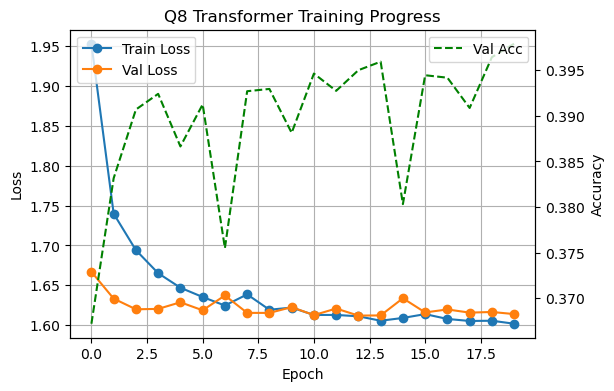

✅ Saved new best model (ValAcc=39.79%)
✅ Training complete. Best ValAcc=39.79%

--- Evaluating Best Transformer (Q8) Model on Test Set ---


C:\Users\rombo\AppData\Local\Temp\ipykernel_27732\390954850.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_q8_transformer.load_state_dict(torch.load(save_path_t

FINAL TEST (Q8 Transformer): Loss=1.6112, Accuracy=39.79%


In [17]:
import math, torch, torch.nn as nn
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import Counter
import gc # Garbage collector

# -------------------------------
# Setup
# -------------------------------
# This model uses the AA_PAD_INDEX (0) for the embedding padding
PAD_IDX = aa_to_int['PAD'] 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- CHANGED FOR Q8 ---
model_q8_transformer = PSSTransformer(
    vocab_size=AA_VOCAB_SIZE,
    d_model=192, n_heads=6, n_layers=3, d_ff=768,
    num_classes=Q8_NUM_CLASSES, # (8)
    pad_idx=PAD_IDX, # Input pad index (0)
    dropout=0.1, max_len=X_train_t.size(1)
).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=Q8_PAD_INDEX, label_smoothing=0.05)
print("Using Q8_PAD_INDEX=8 for loss (NO class weights).")
# Use LR from your Q3 Transformer cell (a20450fe)
MAX_LR = 3e-3 
optimizer = torch.optim.AdamW(model_q8_transformer.parameters(), lr=MAX_LR, weight_decay=1e-2)
EPOCHS = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR,
    steps_per_epoch=len(train_loader_q8), # <-- CHANGED FOR Q8
    epochs=EPOCHS
)
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

# ------------------------------_
# Training loop (Self-contained, like your original)
# ------------------------------_
ACCUM_STEPS, CLIP_NORM = 4, 1.0
train_losses, val_losses, val_accs = [], [], []

# --- Variables for early stopping ---
best_val_acc = 0.0
epochs_no_improve = 0
patience = 5 # Stop after 5 epochs of no improvement
save_path_transformer = "best_q8_transformer.pt"

for epoch in range(EPOCHS):
    model_q8_transformer.train(); total_loss = 0.0
    # --- CHANGED FOR Q8 ---
    pbar = tqdm(train_loader_q8, desc=f"Epoch {epoch+1}/{EPOCHS} — Training (Q8)", leave=False)
    optimizer.zero_grad(set_to_none=True)

    for step, (X, Y, L) in enumerate(pbar, 1):
        X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
        
        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits = model_q8_transformer(X, L)
            # Use logits.transpose, which is correct for Transformers
            loss = criterion(logits.transpose(1, 2), Y) / ACCUM_STEPS 
            
        scaler.scale(loss).backward()

        if step % ACCUM_STEPS == 0 or step == len(train_loader_q8):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model_q8_transformer.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        total_loss += loss.item() * ACCUM_STEPS
        pbar.set_postfix(loss=f"{loss.item() * ACCUM_STEPS:.4f}")

    avg_train_loss = total_loss / len(train_loader_q8)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model_q8_transformer.eval(); val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad(), autocast(device_type="cuda", enabled=torch.cuda.is_available()):
        # --- CHANGED FOR Q8 ---
        for X, Y, L in val_loader_q8:
            X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
            logits = model_q8_transformer(X, L)
            
            # Use logits.transpose for validation loss
            val_loss += criterion(logits.transpose(1, 2), Y).item()
            preds = logits.argmax(dim=-1)
            
            # --- CHANGED FOR Q8 ---
            mask = Y != Q8_PAD_INDEX # (mask out 8)
            correct += (preds[mask] == Y[mask]).sum().item()
            total += mask.sum().item()

    avg_val_loss = val_loss / len(val_loader_q8)
    val_acc = correct / total if total > 0 else 0.0 
    val_losses.append(avg_val_loss); val_accs.append(val_acc)

    tqdm.write(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}, ValAcc (Q8)={val_acc*100:.2f}%")

    # Live plot
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='o')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(val_accs, 'g--', label='Val Acc')
    ax2.set_ylabel('Accuracy')
    ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
    plt.title('Q8 Transformer Training Progress') # <-- CHANGED FOR Q8
    plt.show()
    
    # --- Early stopping check ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model_q8_transformer.state_dict(), save_path_transformer)
        tqdm.write(f"✅ Saved new best model (ValAcc={val_acc*100:.2f}%)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            tqdm.write(f"⏹️ Early stopping at epoch {epoch+1}")
            break

print(f"✅ Training complete. Best ValAcc={best_val_acc*100:.2f}%")

# --- Final Test Evaluation ---
print("\n--- Evaluating Best Transformer (Q8) Model on Test Set ---")
if best_val_acc > 0: 
    model_q8_transformer.load_state_dict(torch.load(save_path_transformer))
model_q8_transformer.eval()
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad(), autocast(device_type="cuda", enabled=torch.cuda.is_available()):
    for X, Y, L in test_loader_q8:
        X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
        logits = model_q8_transformer(X, L)
        
        # --- FIX: Use test_loss, not val_loss ---
        test_loss += criterion(logits.transpose(1, 2), Y).item()
        preds = logits.argmax(dim=-1)
        mask = (Y != Q8_PAD_INDEX)
        correct += (preds[mask] == Y[mask]).sum().item()
        total += mask.sum().item()

avg_test_loss = test_loss / len(test_loader_q8)
test_acc = correct / total if total > 0 else 0.0
print(f"FINAL TEST (Q8 Transformer): Loss={avg_test_loss:.4f}, Accuracy={test_acc*100:.2f}%")


# --- Clean up memory ---
del model_q8_transformer, optimizer, criterion, scheduler, scaler
gc.collect()
torch.cuda.empty_cache()

### Hybrid Model Definition and Training (Q8)

This cell defines and trains the `CNN_BiLSTM_Transformer` hybrid model on the **Q8 task**.
1.  **Definition**: The model architecture is defined (Embedding -> CNN -> BiLSTM -> Transformer -> Classifier).
2.  **Initialization**: The model is initialized to output `Q8_NUM_CLASSES` (8 classes).
3.  **Training**: A full training loop is run using the `train_loader_q8` and `val_loader_q8`. The loss function ignores `Q8_PAD_INDEX` (8) and does **not** use class weights.
4.  **Evaluation**: The best model (`best_hybrid_model_q8.pt`) is loaded and evaluated on the `test_loader_q8`.

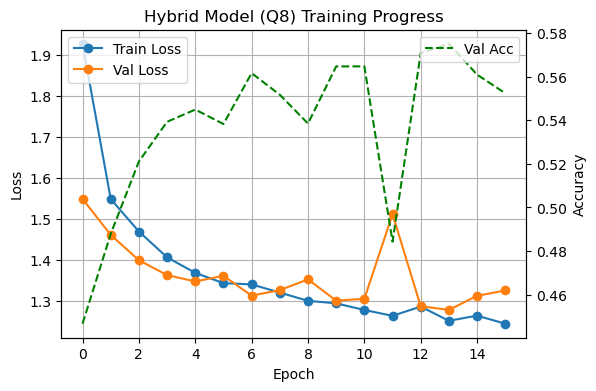

Epoch 17: Train=1.2285, Val=1.2951, ValAcc (Q8)=56.60%
⏹️ Early stopping at epoch 17
✅ Loaded best model with ValAcc=57.51%

--- Evaluating Best Hybrid (Q8) Model on Test Set ---


C:\Users\rombo\AppData\Local\Temp\ipykernel_27732\753785779.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_hybrid_q8.load_state_dict(torch.load(save_path)) # <-

FINAL TEST (Q8 Hybrid): Loss=1.2706, Accuracy=57.97%


In [18]:
import math, torch, torch.nn as nn
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc
# -------------------------------
# Hybrid model (CNN + BiLSTM + Transformer)
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1632):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        T = x.size(1)
        return x * math.sqrt(x.size(-1)) + self.pe[:T, :]


class CNN_BiLSTM_Transformer(nn.Module):
    def __init__(self, vocab_size, num_classes, pad_idx=0,
                 d_model=192, cnn_channels=128, lstm_hidden=256,
                 n_heads=6, n_layers=3, d_ff=768, dropout=0.1, max_len=1632):
        super().__init__()
        self.pad_idx = pad_idx

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.posenc = PositionalEncoding(d_model, max_len)

        self.cnn_block = nn.Sequential(
            nn.Conv1d(d_model, cnn_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_channels),
            nn.Conv1d(cnn_channels, d_model, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(d_model),
        )

        self.bilstm = nn.LSTM(d_model, lstm_hidden, num_layers=1,
                              batch_first=True, bidirectional=True)
        lstm_out_dim = lstm_hidden * 2

        enc_layer = nn.TransformerEncoderLayer(
            d_model=lstm_out_dim, nhead=n_heads,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True, activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(lstm_out_dim, num_classes)

        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, x, lengths):
        B, T = x.size()
        device = x.device
        mask = torch.arange(T, device=device).unsqueeze(0) >= lengths.unsqueeze(1)

        h = self.embedding(x)
        h = self.posenc(h)
        h = h.transpose(1, 2)
        h = self.cnn_block(h).transpose(1, 2)

        packed = nn.utils.rnn.pack_padded_sequence(
            h, lengths.cpu(), batch_first=True, enforce_sorted=False)
        h, _ = self.bilstm(packed)
        h, _ = nn.utils.rnn.pad_packed_sequence(h, batch_first=True, total_length=T)

        h = self.transformer(h, src_key_padding_mask=mask)
        h = self.dropout(h)
        return self.classifier(h)


# -------------------------------
# Training setup
# -------------------------------
PAD_IDX = aa_to_int['PAD'] 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- CHANGED FOR Q8 ---
model_hybrid_q8 = CNN_BiLSTM_Transformer(
    vocab_size=AA_VOCAB_SIZE, 
    num_classes=Q8_NUM_CLASSES, # <-- CHANGED
    pad_idx=PAD_IDX, 
    d_model=192, 
    cnn_channels=128,
    lstm_hidden=96, 
    n_heads=6, 
    n_layers=2, 
    d_ff=512,
    dropout=0.1, 
    max_len=X_train_t.size(1)
).to(DEVICE)

print(f"Hybrid Model (Q8) Initialized. D_model=192, LSTM_hidden=96, Heads=6")

# --- CHANGED FOR Q8 ---
# Use Q8_PAD_INDEX (8) for loss and no class weights
criterion = nn.CrossEntropyLoss(ignore_index=Q8_PAD_INDEX, label_smoothing=0.05)
print("Using Q8_PAD_INDEX=8 for loss (no class weights).")

# Use LR from your Q3 Hybrid cell
MAX_LR = 3e-3 
optimizer = torch.optim.AdamW(model_hybrid_q8.parameters(), lr=MAX_LR, weight_decay=1e-2)

EPOCHS, ACCUM_STEPS, CLIP_NORM, patience = 25, 4, 1.0, 3
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR,
    steps_per_epoch=len(train_loader_q8), # <-- CHANGED
    epochs=EPOCHS
)
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

best_val_acc, no_improve, early_stop = 0.0, 0, False
# --- CHANGED FOR Q8 ---
save_path = "best_hybrid_model_q8.pt"

train_losses, val_losses, val_accs = [], [], []

# -------------------------------
# Training loop
# -------------------------------
for epoch in range(EPOCHS):
    model_hybrid_q8.train()
    total_loss = 0.0
    # --- CHANGED FOR Q8 ---
    pbar = tqdm(train_loader_q8, desc=f"Epoch {epoch+1}/{EPOCHS} — Training (Q8 Hybrid)", leave=False)
    optimizer.zero_grad(set_to_none=True)

    for step, (X, Y, L) in enumerate(pbar, 1):
        X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits = model_hybrid_q8(X, L) # <-- CHANGED
            loss = criterion(logits.transpose(1, 2), Y) / ACCUM_STEPS
        scaler.scale(loss).backward()

        if step % ACCUM_STEPS == 0 or step == len(train_loader_q8): # <-- CHANGED
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model_hybrid_q8.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
        total_loss += loss.item() * ACCUM_STEPS
        pbar.set_postfix(loss=f"{loss.item()*ACCUM_STEPS:.4f}")

    avg_train_loss = total_loss / len(train_loader_q8) # <-- CHANGED
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model_hybrid_q8.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad(), autocast(device_type="cuda", enabled=torch.cuda.is_available()):
        # --- CHANGED FOR Q8 ---
        for X, Y, L in val_loader_q8:
            X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
            logits = model_hybrid_q8(X, L) # <-- CHANGED
            val_loss += criterion(logits.transpose(1, 2), Y).item()
            preds = logits.argmax(dim=-1)
            # --- CHANGED FOR Q8 ---
            mask = (Y != Q8_PAD_INDEX) 
            correct += (preds[mask] == Y[mask]).sum().item()
            total += mask.sum().item()

    avg_val_loss = val_loss / len(val_loader_q8) # <-- CHANGED
    val_acc = correct / total if total > 0 else 0.0
    val_losses.append(avg_val_loss); val_accs.append(val_acc)

    # --- CHANGED FOR Q8 ---
    tqdm.write(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}, ValAcc (Q8)={val_acc*100:.2f}%")

    # --- Early stopping ---
    if val_acc > best_val_acc:
        best_val_acc, no_improve = val_acc, 0
        torch.save(model_hybrid_q8.state_dict(), save_path) # <-- CHANGED
        tqdm.write(f"✅ Saved new best model (ValAcc={val_acc*100:.2f}%)")
    else:
        no_improve += 1
        if no_improve >= patience:
            tqdm.write(f"⏹️ Early stopping at epoch {epoch+1}")
            early_stop = True
            break
    
    # --- Live plot ---
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='o')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(val_accs, 'g--', label='Val Acc')
    ax2.set_ylabel('Accuracy')
    ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
    # --- CHANGED FOR Q8 ---
    plt.title('Hybrid Model (Q8) Training Progress')
    plt.show()

if early_stop:
    model_hybrid_q8.load_state_dict(torch.load(save_path)) # <-- CHANGED
    print(f"✅ Loaded best model with ValAcc={best_val_acc*100:.2f}%")
else:
    print(f"✅ Training complete. Best ValAcc={best_val_acc*100:.2f}%")

# --- [NEW] Final Test Evaluation ---
print("\n--- Evaluating Best Hybrid (Q8) Model on Test Set ---")
if best_val_acc > 0: # Only load if we saved a model
    model_hybrid_q8.load_state_dict(torch.load(save_path))
model_hybrid_q8.eval()
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad(), autocast("cuda", enabled=torch.cuda.is_available()):
    for X, Y, L in test_loader_q8: # <-- CHANGED
        X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
        logits = model_hybrid_q8(X, L)
        test_loss += criterion(logits.transpose(1, 2), Y).item()
        preds = logits.argmax(dim=-1)
        mask = (Y != Q8_PAD_INDEX) # <-- CHANGED
        correct += (preds[mask] == Y[mask]).sum().item()
        total += mask.sum().item()

avg_test_loss = test_loss / len(test_loader_q8) # <-- CHANGED
test_acc = correct / total if total > 0 else 0.0
print(f"FINAL TEST (Q8 Hybrid): Loss={avg_test_loss:.4f}, Accuracy={test_acc*100:.2f}%")


# --- Clean up memory ---
del model_hybrid_q8, optimizer, criterion, scheduler, scaler
gc.collect()
torch.cuda.empty_cache()

In [19]:
torch.cuda.empty_cache()

## Hyperparameter Tuning (Optuna) for Hybrid Model (Q8)

This cell uses the `Optuna` library to perform an automated hyperparameter search for the `CNN_BiLSTM_Transformer` model on the **Q8 task**.

* The `objective` function defines the search space (e.g., for `lr`, `d_model`, `lstm_hidden`). It trains a model using the **Q8 data loaders** for a few epochs and returns the validation accuracy.
* A `finally` block with `gc.collect()` and `torch.cuda.empty_cache()` is included to prevent CUDA memory errors between trials.
* `study.optimize` runs the search, and the best trial's parameters are printed at the end.

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import torch.nn.functional as F
import gc # Import the garbage collector

# ===================================================================
# MODEL DEFINITIONS (Copied from your previous cell)
# ===================================================================

# (PositionalEncoding and CNN_BiLSTM_Transformer classes are assumed 
# to be defined in a previous cell, as in your example)

# ===========================================================
# OPTUNA SCRIPT (Q8)
# ===========================================================

MAX_EPOCHS_PER_TRIAL = 8 
N_TRIALS = 20

def objective(trial):
    """
    This is the main function that Optuna will call for each trial.
    It defines, trains, and validates one model with a set of hyperparameters.
    """
    
    # Initialize variables to None for the 'finally' block
    model_hybrid = None
    optimizer = None
    criterion = None
    scheduler = None
    scaler = None

    try:
        # --- 1. Define Hyperparameter Search Space ---
        lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        d_model = trial.suggest_categorical("d_model", [128, 192, 256])
        lstm_hidden = trial.suggest_categorical("lstm_hidden", [64, 128, 256])
        n_layers = trial.suggest_int("n_layers", 1, 3) # Transformer layers
        dropout = trial.suggest_float("dropout", 0.1, 0.3)
        
        n_heads = 8 
        if (lstm_hidden * 2) % n_heads != 0:
            raise optuna.TrialPruned(f"lstm_hidden*2 ({lstm_hidden*2}) not divisible by n_heads ({n_heads})")

        # --- 2. Create Model and Optimizer ---
        try:
            max_len = X_train_t.size(1)
        except NameError:
            print("Warning: 'X_train_t' not found. Defaulting max_len to 1632.", file=sys.stderr)
            max_len = 1632 

        # --- CHANGED FOR Q8 ---
        model_hybrid = CNN_BiLSTM_Transformer(
            vocab_size=AA_VOCAB_SIZE, 
            num_classes=Q8_NUM_CLASSES,    # <-- CHANGED
            pad_idx=aa_to_int['PAD'],  # <-- CHANGED (Input pad index is 0)
            d_model=d_model, 
            cnn_channels=128, 
            lstm_hidden=lstm_hidden, 
            n_heads=n_heads, 
            n_layers=n_layers, 
            d_ff=lstm_hidden * 2 * 4, 
            dropout=dropout, 
            max_len=max_len
        ).to(DEVICE)

        # --- CHANGED FOR Q8 ---
        # Use Q8_PAD_INDEX (8) for loss
        criterion = nn.CrossEntropyLoss(ignore_index=Q8_PAD_INDEX, label_smoothing=0.05)
        optimizer = torch.optim.AdamW(model_hybrid.parameters(), lr=lr, weight_decay=1e-3)
        
        ACCUM_STEPS, CLIP_NORM = 4, 1.0
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=lr, 
            steps_per_epoch=len(train_loader_q8), # <-- CHANGED
            epochs=MAX_EPOCHS_PER_TRIAL
        )
        scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

        best_val_acc = 0.0

        # --- 3. Training & Validation Loop ---
        for epoch in range(MAX_EPOCHS_PER_TRIAL):
            model_hybrid.train()
            total_loss = 0.0
            
            # --- CHANGED FOR Q8 ---
            for step, (X, Y, L) in enumerate(train_loader_q8, 1):
                X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
                
                with autocast(device_type="cuda" if DEVICE.type == "cuda" else "cpu", enabled=torch.cuda.is_available()):
                    logits = model_hybrid(X, L)
                    loss = criterion(logits.transpose(1, 2), Y) / ACCUM_STEPS
                
                scaler.scale(loss).backward()

                if step % ACCUM_STEPS == 0 or step == len(train_loader_q8): # <-- CHANGED
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model_hybrid.parameters(), CLIP_NORM)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                    scheduler.step()

                total_loss += loss.item() * ACCUM_STEPS

            # --- Validation ---
            model_hybrid.eval()
            val_loss, correct, total = 0.0, 0, 0
            with torch.no_grad(), autocast(device_type="cuda" if DEVICE.type == "cuda" else "cpu", enabled=torch.cuda.is_available()):
                # --- CHANGED FOR Q8 ---
                for X, Y, L in val_loader_q8:
                    X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
                    logits = model_hybrid(X, L)
                    val_loss += criterion(logits.transpose(1, 2), Y).item()
                    preds = logits.argmax(dim=-1)
                    # --- CHANGED FOR Q8 ---
                    mask = (Y != Q8_PAD_INDEX) # (mask out 8)
                    correct += (preds[mask] == Y[mask]).sum().item()
                    total += mask.sum().item()

            avg_val_loss = val_loss / len(val_loader_q8) # <-- CHANGED
            val_acc = correct / total if total > 0 else 0
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc

            trial.report(val_acc, epoch)
            
            if trial.should_prune():
                raise optuna.TrialPruned(f"Pruned at epoch {epoch+1}")

        return best_val_acc

    except optuna.TrialPruned as e:
        raise e
    except Exception as e:
        print(f"Trial failed with error: {e}", file=sys.stderr)
        return 0.0 # Return a bad score
    
    finally:
        # --- THIS IS THE FIX ---
        # Manually delete large objects and clear the GPU cache
        # This ensures memory is freed before the next trial starts.
        del model_hybrid, optimizer, criterion, scheduler, scaler
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# ===========================================================
# START THE HYPERPARAMETER STUDY (Q8)
# ===========================================================

# --- CHANGED FOR Q8 ---
print("Starting Optuna hyperparameter study (Q8)...") 
print(f"This will run {N_TRIALS} trials, each up to {MAX_EPOCHS_PER_TRIAL} epochs.")

pruner = optuna.pruners.MedianPruner(n_warmup_steps=2)
study = optuna.create_study(direction="maximize", pruner=pruner)

try:
    study.optimize(
        objective, 
        n_trials=N_TRIALS, 
        timeout=10200 # ~3 hour timeout
    )
except KeyboardInterrupt:
    print("Study interrupted by user.")


# ===========================================================
# SHOW RESULTS (Q8)
# ===========================================================

print("\nHyperparameter study complete!")

if len(study.trials) > 0:
    # --- CHANGED FOR Q8 ---
    print("\n--- Best Trial (Q8) ---")
    try:
        print(f"  Value (Max ValAcc): {study.best_value:.4f}")
        print("  Params: ")
        for key, value in study.best_params.items():
            print(f"    {key}: {value}")
    except ValueError:
        print("No trials completed successfully.")

    try:
        import plotly
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.show()
        fig2 = optuna.visualization.plot_param_importances(study)
        fig2.show()
        
        plot_params = [param for param in ["lr", "d_model", "lstm_hidden", "n_layers", "dropout"] 
                       if param in study.best_params]
        
        if len(plot_params) >= 2:
            fig3 = optuna.visualization.plot_contour(study, params=plot_params[:2])
            fig3.show()

    except ImportError:
        print("\nInstall 'plotly' to see visualizations:")
        print("  pip install plotly")
    except (ValueError, RuntimeError) as e:
        print(f"\nCould not display visualizations: {e}")
else:
    print("No trials were completed. Please check for errors in the logs above.")

[I 2025-11-10 16:21:18,117] A new study created in memory with name: no-name-8d91eeb6-d48e-4fab-ad13-ef7cfc984b98


Starting Optuna hyperparameter study (Q8)...
This will run 20 trials, each up to 8 epochs.


[I 2025-11-10 16:29:34,118] Trial 0 finished with value: 0.5640138408304498 and parameters: {'lr': 0.0007270214087592517, 'd_model': 256, 'lstm_hidden': 256, 'n_layers': 1, 'dropout': 0.22669462626424222}. Best is trial 0 with value: 0.5640138408304498.
[I 2025-11-10 16:35:25,945] Trial 1 finished with value: 0.5503346134834024 and parameters: {'lr': 0.001421768042116938, 'd_model': 128, 'lstm_hidden': 64, 'n_layers': 2, 'dropout': 0.25610038186169204}. Best is trial 0 with value: 0.5640138408304498.
[W 2025-11-10 17:40:39,604] Trial 2 failed with parameters: {'lr': 0.0005572828398997756, 'd_model': 128, 'lstm_hidden': 256, 'n_layers': 3, 'dropout': 0.20660982633803554} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\rombo\anaconda3\envs\neuralnet\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\rombo\AppData\Local\Temp\ipykernel_27732\1925730869.py", line 10

Study interrupted by user.

Hyperparameter study complete!

--- Best Trial (Q8) ---
  Value (Max ValAcc): 0.5640
  Params: 
    lr: 0.0007270214087592517
    d_model: 256
    lstm_hidden: 256
    n_layers: 1
    dropout: 0.22669462626424222


## Running the best paramaters 


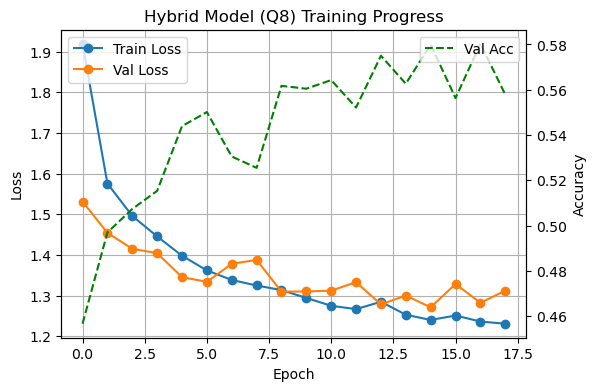

Epoch 19: Train=1.2144, Val=1.2781, ValAcc (Q8)=57.69%
⚠️ No improvement for 4/4 epochs (ValAcc=57.69%)
⏹️ Early stopping triggered at epoch 19
✅ Loaded best model with ValAcc=58.00%

--- Evaluating Best Hybrid (Q8) Model on Test Set ---


C:\Users\rombo\AppData\Local\Temp\ipykernel_27732\2368290457.py:136: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\rombo\AppData\Local\Temp\ipykernel_27732\23682904

FINAL TEST (Q8 Hybrid): Loss=1.2669, Accuracy=58.39%


In [ ]:
import math, torch, torch.nn as nn
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc

# ===========================================================
# TRAINING CONFIG (Q8)
# ===========================================================
# Use the AA pad index (0) for the embedding layer
PAD_IDX = aa_to_int['PAD'] 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- CHANGED FOR Q8 ---
model_hybrid_q8 = CNN_BiLSTM_Transformer(
    vocab_size=AA_VOCAB_SIZE, 
    num_classes=Q8_NUM_CLASSES, # <-- CHANGED
    pad_idx=PAD_IDX, # Input pad index (0)
    d_model=192, 
    cnn_channels=128,
    lstm_hidden=128, # Your value
    n_heads=8,       # Your value
    n_layers=1, 
    d_ff=512,
    dropout=0.16,    # Your value
    max_len=X_train_t.size(1)
).to(DEVICE)

print(f"Hybrid Model (Q8) Initialized. D_model=192, LSTM_hidden=128, Heads=8")

# --- CHANGED FOR Q8 ---
# Use Q8_PAD_INDEX (8) for loss and no class weights
criterion = nn.CrossEntropyLoss(ignore_index=Q8_PAD_INDEX, label_smoothing=0.05)
print("Using Q8_PAD_INDEX=8 for loss (no class weights).")

# Use LR from your Q3 Hybrid cell
MAX_LR = 3e-3 
optimizer = torch.optim.AdamW(model_hybrid_q8.parameters(), lr=MAX_LR, weight_decay=1e-3) # Your weight decay

EPOCHS, ACCUM_STEPS, CLIP_NORM, patience = 30, 4, 1.0, 4 # Your params
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR,
    steps_per_epoch=len(train_loader_q8), # <-- CHANGED
    epochs=EPOCHS
)
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

best_val_acc, no_improve, early_stop = 0.0, 0, False
# --- CHANGED FOR Q8 ---
save_path = "best_hybrid_model_q8.pt"

train_losses, val_losses, val_accs = [], [], []

# ===========================================================
# TRAINING LOOP (Q8)
# ===========================================================
for epoch in range(EPOCHS):
    model_hybrid_q8.train()
    total_loss = 0.0
    # --- CHANGED FOR Q8 ---
    pbar = tqdm(train_loader_q8, desc=f"Epoch {epoch+1}/{EPOCHS} — Training (Q8 Hybrid)", leave=False)
    optimizer.zero_grad(set_to_none=True)

    for step, (X, Y, L) in enumerate(pbar, 1):
        X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits = model_hybrid_q8(X, L) # <-- CHANGED
            loss = criterion(logits.transpose(1, 2), Y) / ACCUM_STEPS
        scaler.scale(loss).backward()

        if step % ACCUM_STEPS == 0 or step == len(train_loader_q8): # <-- CHANGED
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model_hybrid_q8.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
        total_loss += loss.item() * ACCUM_STEPS
        pbar.set_postfix(loss=f"{loss.item()*ACCUM_STEPS:.4f}", lr=f"{scheduler.get_last_lr()[0]:.2e}")

    avg_train_loss = total_loss / len(train_loader_q8) # <-- CHANGED
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model_hybrid_q8.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad(), autocast(device_type="cuda", enabled=torch.cuda.is_available()):
        # --- CHANGED FOR Q8 ---
        for X, Y, L in val_loader_q8:
            X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
            logits = model_hybrid_q8(X, L) # <-- CHANGED
            val_loss += criterion(logits.transpose(1, 2), Y).item()
            preds = logits.argmax(dim=-1)
            # --- CHANGED FOR Q8 ---
            mask = (Y != Q8_PAD_INDEX) 
            correct += (preds[mask] == Y[mask]).sum().item()
            total += mask.sum().item()

    avg_val_loss = val_loss / len(val_loader_q8) # <-- CHANGED
    val_acc = correct / total if total > 0 else 0.0
    val_losses.append(avg_val_loss); val_accs.append(val_acc)

    # --- CHANGED FOR Q8 ---
    tqdm.write(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}, ValAcc (Q8)={val_acc*100:.2f}%")

    # --- Early stopping ---
    min_delta = 0.002
    if val_acc > best_val_acc + min_delta:
        best_val_acc, no_improve = val_acc, 0
        torch.save(model_hybrid_q8.state_dict(), save_path) # <-- CHANGED
        tqdm.write(f"✅ Saved new best model (ValAcc={val_acc*100:.2f}%)")
    else:
        no_improve += 1
        tqdm.write(f"⚠️ No improvement for {no_improve}/{patience} epochs (ValAcc={val_acc*100:.2f}%)")
        if no_improve >= patience:
            tqdm.write(f"⏹️ Early stopping triggered at epoch {epoch+1}")
            early_stop = True
            break
    
    # --- Live plot ---
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='o')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(val_accs, 'g--', label='Val Acc')
    ax2.set_ylabel('Accuracy')
    ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
    # --- CHANGED FOR Q8 ---
    plt.title('Hybrid Model (Q8) Training Progress')
    plt.show()

if early_stop:
    model_hybrid_q8.load_state_dict(torch.load(save_path)) # <-- CHANGED
    print(f"✅ Loaded best model with ValAcc={best_val_acc*100:.2f}%")
else:
    print(f"✅ Training complete. Best ValAcc={best_val_acc*100:.2f}%")

# --- Final Test Evaluation ---
print("\n--- Evaluating Best Hybrid (Q8) Model on Test Set ---")
if best_val_acc > 0: # Only load if we saved a model
    model_hybrid_q8.load_state_dict(torch.load(save_path))
model_hybrid_q8.eval()
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad(), autocast("cuda", enabled=torch.cuda.is_available()):
    for X, Y, L in test_loader_q8: # <-- CHANGED
        X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
        logits = model_hybrid_q8(X, L)
        test_loss += criterion(logits.transpose(1, 2), Y).item()
        preds = logits.argmax(dim=-1)
        mask = (Y != Q8_PAD_INDEX) # <-- CHANGED
        correct += (preds[mask] == Y[mask]).sum().item()
        total += mask.sum().item()

avg_test_loss = test_loss / len(test_loader_q8) # <-- CHANGED
test_acc = correct / total if total > 0 else 0.0
print(f"FINAL TEST (Q8 Hybrid): Loss={avg_test_loss:.4f}, Accuracy={test_acc*100:.2f}%")


# --- Clean up memory ---
del model_hybrid_q8, optimizer, criterion, scheduler, scaler
gc.collect()
torch.cuda.empty_cache()